# 딥러닝 무작정 실행해보기 : MNIST

## 라이브러리 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

## 데이터셋 불러오기

- 데이터셋 다운로드

In [2]:
training_dataset = datasets.MNIST(root='dataset',
                                  train=True,
                                  download=True,
                                  transform=ToTensor(),
                                  )

test_dataset = datasets.MNIST(root='dataset',
                              train=False,
                              download=False,
                              transform=ToTensor(),
                              )

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17443010.16it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 489935.99it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4441594.55it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9338494.49it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



- 각 변수에 데이터셋이 담겨있는 상태

In [3]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

## 데이터셋 구경하기

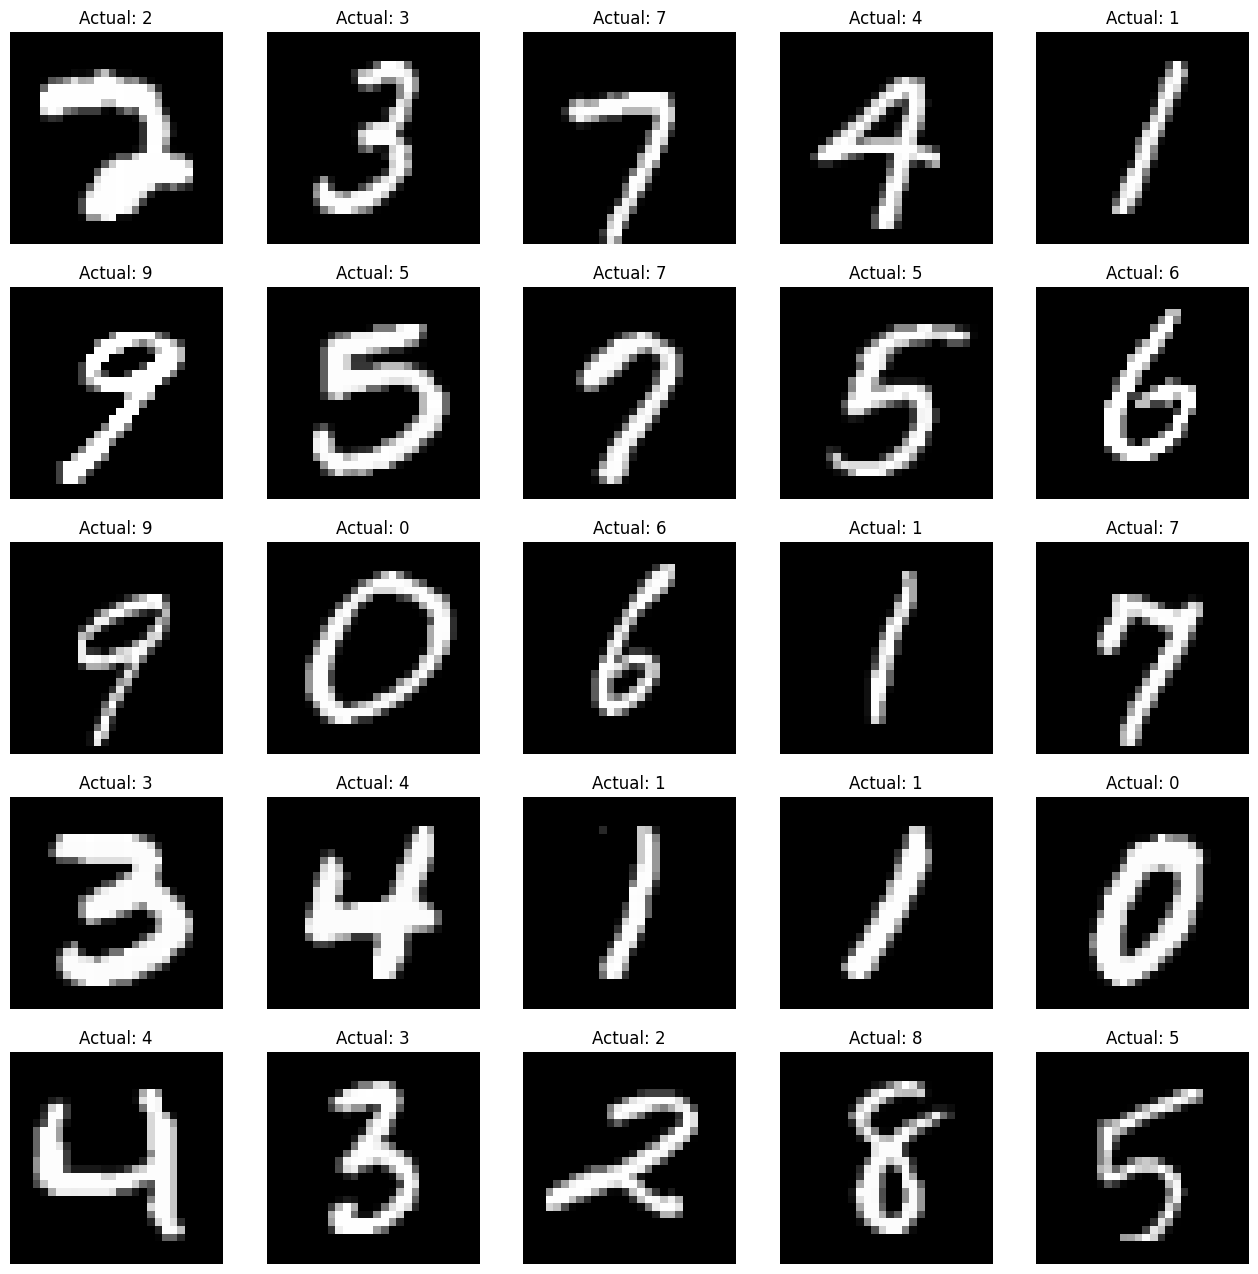

In [5]:
figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]

    plt.title(f'Actual: {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

## 데이터로더 생성하기
- 데이터셋을 순차적으로 조회 가능하도록 만드는 작업

In [6]:
batch_size = 32

train_dataloader = DataLoader(dataset=training_dataset,
                              batch_size=batch_size
                              )

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size
                             )

In [7]:
train_dataloader

In [8]:
for x, y in train_dataloader :
    print(f'학습 데이터의 형태 [N, C, H, W] : {x.shape}')
    print(f'정답 데이터의 형태 : {y.shape}')
    break

학습 데이터의 형태 [N, C, H, W] : torch.Size([32, 1, 28, 28])
정답 데이터의 형태 : torch.Size([32])


## 연산 장치 설정

In [10]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

print(f'연산 장치 : {device}')

연산 장치 : cpu


## 모델 정의 및 생성

- 모델의 형태 구성

In [9]:
class BasicNN(nn.Module) :
    def __init__(self) :
        super().__init__()
        self.flatten = nn.Flatten()
        self.basicNN = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x) :
        x = self.flatten(x)
        x = self.basicNN(x)
        return x

In [11]:
model = BasicNN().to(device)
model

BasicNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (basicNN): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

- 손실 함수와 옵티마이저 설정

In [12]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model.parameters())

In [13]:
loss_fn

CrossEntropyLoss()

In [14]:
optim

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

- 학습 절차를 함수화

In [15]:
def train(dataloader, model, loss_fn, optim) :
    model.train()
    size = len(dataloader.dataset)

    for batch, (x, y) in enumerate(dataloader) :
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        loss = loss_fn(y_pred, y)

        optim.zero_grad()
        loss.backward()
        optim.step()

        if batch % 100 == 0 :
            loss = loss.item()
            current = (batch+1) * len(x)
            print(f'[{current:5d}/{size:5d}] | loss: {loss:.4f}')

In [16]:
def test(dataloader, model, loss_fn) :
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss = 0
    correct = 0

    with torch.no_grad() :
        for x, y in dataloader :
            x, y = x.to(device), y.to(device)

            y_pred = model(x)
            test_loss = test_loss + loss_fn(y_pred, y).item()
            correct = correct + (y_pred.argmax(1)==y).type(torch.float).sum().item()

    test_loss = test_loss / num_batches
    correct = correct / size

    print(f'Accuracy: {100*correct:.2f}% | Avg_loss: {test_loss:.4f}')

In [17]:
epochs = 1

for e in range(epochs) :
    print(f'Epoch {e+1}')
    print('--------------------------')

    train(train_dataloader, model, loss_fn, optim)
    test(test_dataloader, model, loss_fn)
    print('--------------------------')

print('==============================')
print('End')

Epoch 1
--------------------------
[   32/60000] | loss: 2.3058
[ 3232/60000] | loss: 0.3826
[ 6432/60000] | loss: 0.3369
[ 9632/60000] | loss: 0.1851
[12832/60000] | loss: 0.2185
[16032/60000] | loss: 0.2991
[19232/60000] | loss: 0.1699
[22432/60000] | loss: 0.1073
[25632/60000] | loss: 0.1831
[28832/60000] | loss: 0.1282
[32032/60000] | loss: 0.5167
[35232/60000] | loss: 0.3111
[38432/60000] | loss: 0.1930
[41632/60000] | loss: 0.2333
[44832/60000] | loss: 0.2041
[48032/60000] | loss: 0.1416
[51232/60000] | loss: 0.1626
[54432/60000] | loss: 0.0547
[57632/60000] | loss: 0.1342
Accuracy: 96.06% | Avg_loss: 0.1247
--------------------------
End


## 테스트 결과 살펴보기

In [18]:
model.eval()

rand_idx = torch.randint(0, 10000, size=(1,)).item()
x, y = test_dataset[rand_idx][0], test_dataset[rand_idx][1]

with torch.no_grad() :
    x = x.to(device)
    y_pred = model(x)

    predicted = y_pred.argmax()
    actual = y

    print(f'Predicted: {predicted} | Actual: {actual}')

Predicted: 3 | Actual: 3


- 시각화 하여 살펴보기

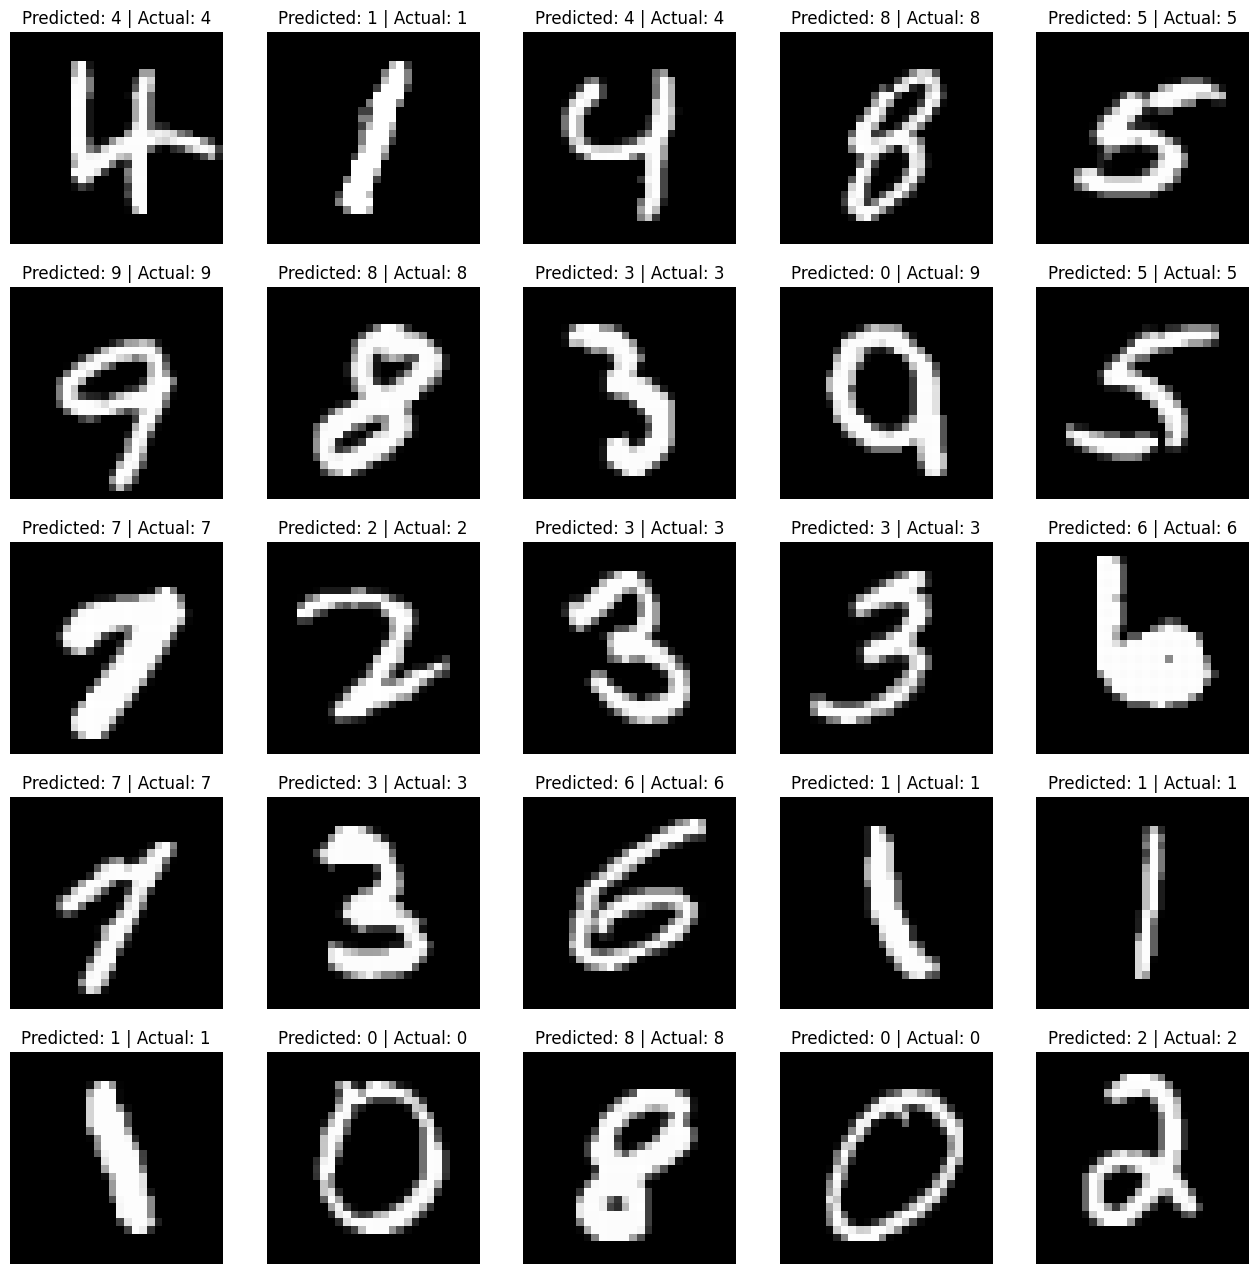

In [23]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    rand_idx = torch.randint(0, 10000, size=(1,)).item()
    x, y = test_dataset[rand_idx][0], test_dataset[rand_idx][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax()
        actual = y

    # print(f'Predicted: {predicted} | Actual: {actual}')
    plt.title(f'Predicted: {predicted} | Actual: {actual}')
    plt.axis("off")
    plt.imshow(x.squeeze(), cmap="gray")

plt.show()

- 틀린 것만 시각화 하여 살펴보기

In [24]:
model.eval()

predicted_list, actual_list = [], []

for i in range(len(test_dataset)) :
    x, y = test_dataset[i][0], test_dataset[i][1]

    with torch.no_grad() :
        x = x.to(device)
        y_pred = model(x)

        predicted = y_pred.argmax().item()
        actual = y

        predicted_list.append(predicted)
        actual_list.append(actual)

In [21]:
predicted_list[:5], actual_list[:5]

([7, 2, 1, 0, 4], [7, 2, 1, 0, 4])

In [22]:
false_idx_list = []

for i in range(len(predicted_list)) :
    if predicted_list[i] != actual_list[i] :
        false_idx_list.append(i)

false_idx_list[:5]

[38, 149, 151, 193, 217]

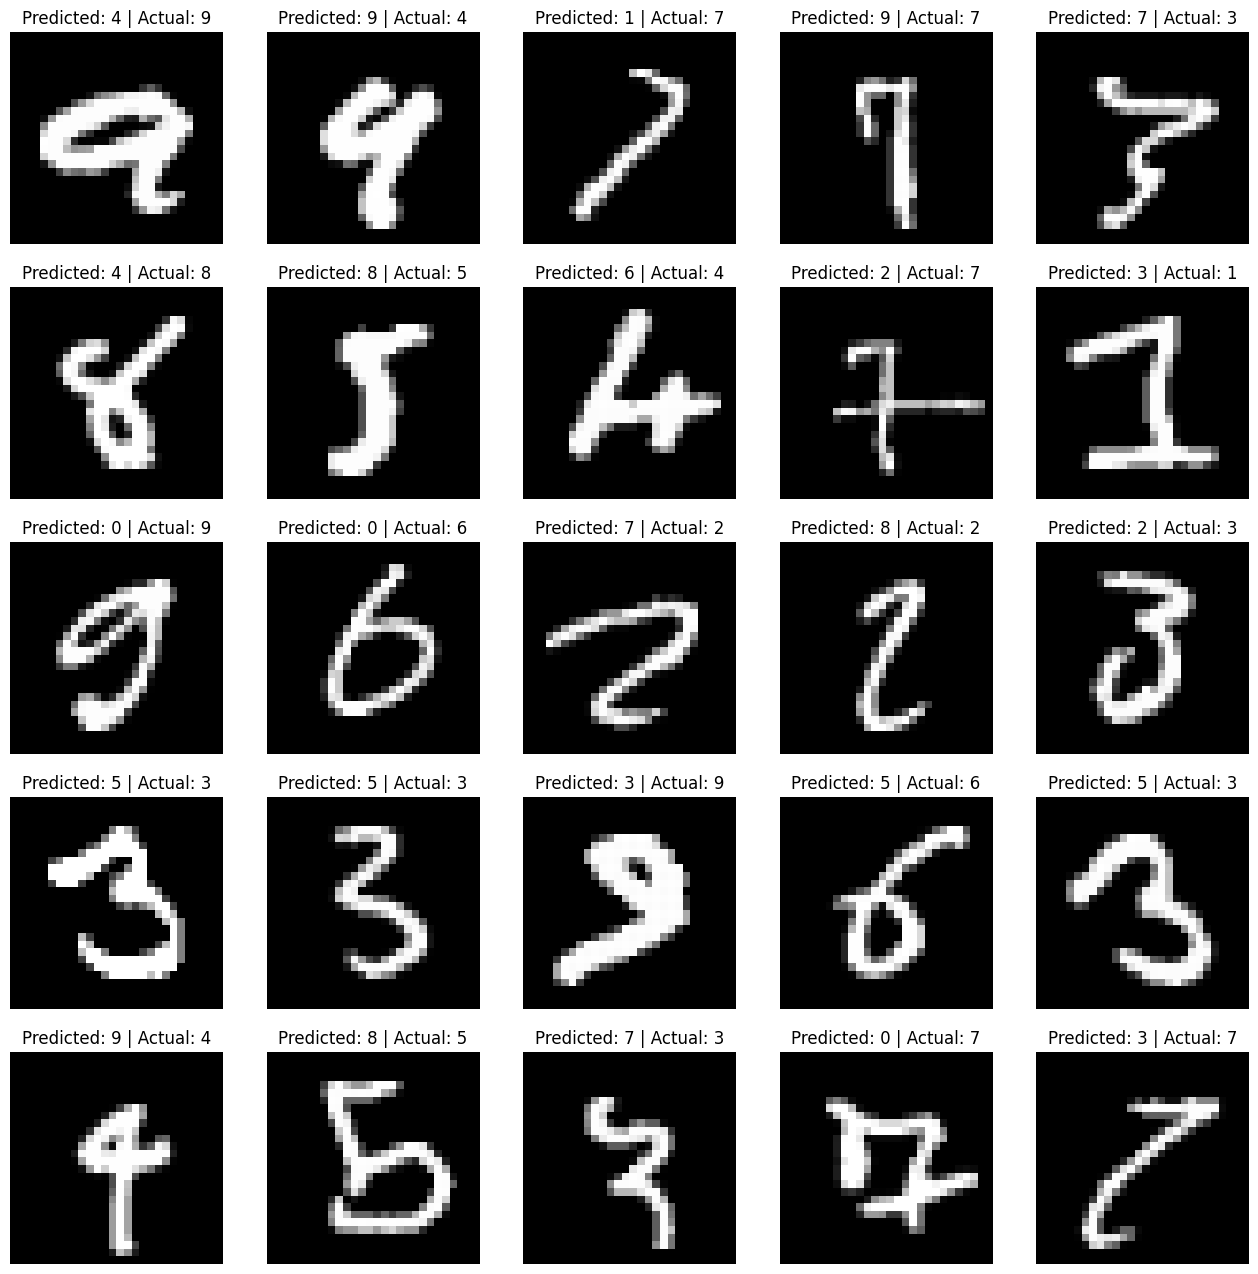

In [25]:
model.eval()

figure = plt.figure(figsize=(16, 16))
cols, rows = 5, 5

for i in range(1, cols*rows+1) :
    figure.add_subplot(rows, cols, i)

    sample_idx = false_idx_list[ torch.randint(len(false_idx_list), size=(1,)).item() ]

    with torch.no_grad() :
        temp_x = test_dataset[ sample_idx ][0]
        temp_y_pred = model(temp_x)

        temp_predicted = temp_y_pred.argmax().item()
        temp_actual = test_dataset[ sample_idx ][1]

    plt.title(f'Predicted: {temp_predicted} | Actual: {temp_actual}')
    plt.axis("off")
    plt.imshow(temp_x.squeeze(), cmap="gray")

plt.show()